In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

In [6]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

In [7]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full-rem-seps-z.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df_cat

,ID,ORyanID_23,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,816891,4000705532455,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,860686,4000705533383,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,1.571297e-06,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,1301188,4000705539941,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,1304538,4000705540034,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,1310001,4000705540064,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-1.023530e-05,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,1520733,4001204758614_extra,stage4,149.891374,2.866981,28107.876953,37826.437500,0.000086,0.000104,-9.313976e-07,...,-9.441206,-9.279022,-9.095134,-9.003501,-8.955496,0.120441,0.213251,0.306832,0.556012,0.731876
3928,1520749,4546055995_extra,stage2,150.383110,2.865367,16320.103516,37787.917969,0.000131,0.000236,7.123858e-05,...,-9.857880,-9.658215,-9.485625,-9.235816,-8.971795,0.162147,0.238640,0.432004,0.592193,0.687256
3929,1523385,4000927318133_extra,stage3,149.789910,2.865132,30540.179688,37782.648438,0.000045,0.000059,1.600747e-05,...,-9.525900,-9.472779,-9.353454,-9.273221,-9.213521,0.262676,0.355466,0.410356,0.489105,0.566003
3930,1524909,4000747939904_extra,stage3,150.450581,2.872371,14702.710938,37956.468750,0.000248,0.000292,7.378556e-06,...,-9.556987,-9.385500,-9.154130,-9.026810,-8.938077,0.153294,0.283249,0.436332,0.600615,0.693621


In [9]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

In [10]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [11]:
df_z_tmp = (
    df_red[['ORyanID_23', 'ID', 'category', 'ALPHA_J2000', 'DELTA_J2000', 'lp_mass_best', 'ez_sfr', 'lp_zBEST', 'ez_z_phot', 'ID_COSMOS2015']]
    .assign(redshift = df_red.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
    .assign(contains_extra = df_red.ORyanID_23.apply(lambda x: 'y' if type(x) == str else 'n'))
)
df_z = df_z_tmp.query('redshift < 1.2').drop(columns = ['contains_extra'])

In [12]:
df_z

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,lp_mass_best,ez_sfr,lp_zBEST,ez_z_phot,ID_COSMOS2015,redshift
0,4000705532455,816891,stage4,150.679846,2.196543,9.28590,0.589695,0.5304,0.519525,590539,0.519525
1,4000705533383,860686,stage3,150.644522,2.237226,10.44862,1.609304,1.1244,1.198015,618751,1.124400
2,4000705539941,1301188,stage2,149.702462,2.654895,8.72372,-0.987761,NaN,0.230293,893328,0.230293
3,4000705540034,1304538,stage3,149.726828,2.658172,9.96798,1.101499,NaN,1.024009,895502,1.024009
4,4000705540064,1310001,stage3,149.701230,2.660343,10.41827,1.083541,0.4864,0.501348,898397,0.486400
...,...,...,...,...,...,...,...,...,...,...,...
3927,4001204758614_extra,1520733,stage4,149.891374,2.866981,9.27097,0.369745,NaN,0.484922,1030872,0.484922
3928,4546055995_extra,1520749,stage2,150.383110,2.865367,9.50357,0.507741,NaN,0.647512,1029954,0.647512
3929,4000927318133_extra,1523385,stage3,149.789910,2.865132,9.53909,0.406027,NaN,0.301645,1031020,0.301645
3930,4000747939904_extra,1524909,stage3,150.450581,2.872371,9.76084,0.637714,NaN,0.855695,1034203,0.855695


### Cross Matching with AGN Catalogues

In [13]:
df_coords = (
    df_z[['ID', 'ALPHA_J2000', 'DELTA_J2000']]
    .rename(columns = {'ALPHA_J2000':'RA','DELTA_J2000':'DEC'})
    .set_index('ID')
)

In [14]:
coords_dict = df_coords.to_dict(orient='index')

In [15]:
with fits.open(f'{cos_dat_fold}/VLA_3GHz_counterpart_array_20170210_paper_smolcic_et_al.fits') as hdul:
    smol_rec = hdul[1].data

In [16]:
smol_rec.names

['ID_VLA',
 'RA_VLA_J2000',
 'DEC_VLA_J2000',
 'MULTI',
 'CAT_CPT',
 'ID_CPT',
 'RA_CPT_J2000',
 'DEC_CPT_J2000',
 'SEP_VLA_CPT',
 'P_FALSE',
 'Z_BEST',
 'FLUX_INT_3GHz',
 'Lradio_10cm',
 'Lradio_21cm',
 'L_TIR_SF',
 'SFR_KENN98',
 'Xray_AGN',
 'MIR_AGN',
 'SED_AGN',
 'Quiescent_MLAGN',
 'SFG',
 'Clean_SFG',
 'HLAGN',
 'MLAGN',
 'Radio_excess',
 'flag_COSMOS2015']

In [17]:
smol_df = Table(smol_rec).to_pandas().query('CAT_CPT == "COSMOS2015     "')

In [18]:
smol_df.flag_COSMOS2015.value_counts()

0     7729
4        6
5        2
11       1
1        1
3        1
8        1
7        1
Name: flag_COSMOS2015, dtype: int64

In [19]:
def getting_smol_info(clsfs_nostrip, flag):
            
    if flag != 0:
        return 'no_COSMOS'
    
    clsfs = []
    for j in clsfs_nostrip:
        clsfs.append(j.strip())
    
    if clsfs[0] == 'true':
        return 'AGN'
    elif clsfs[1] == 'true':
        return 'AGN'
    elif clsfs[2] == 'true':
        return 'AGN'
    elif clsfs[3] == 'true':
        return 'AGN'
    elif clsfs[4] == 'true':
        return 'SFG'
    elif clsfs[5] == 'true':
        return 'SFG'
    elif clsfs[6] == 'true':
        return 'AGN'
    elif clsfs[7] == 'true':
        return 'AGN'
    elif clsfs[8] == 'true':
        return 'AGN'
    else:
        return 'unknown'

In [20]:
smol_clsf = (
    smol_df.assign(gal_clsf = smol_df.progress_apply(lambda row: getting_smol_info(
        [
            row.Xray_AGN, 
            row.MIR_AGN, 
            row.SED_AGN, 
            row.Quiescent_MLAGN, 
            row.SFG, 
            row.Clean_SFG,
            row.HLAGN,
            row.MLAGN,
            row.Radio_excess
        ], 
        row.flag_COSMOS2015), axis = 1)
                  )
)

100%|██████████| 7742/7742 [00:00<00:00, 15020.90it/s]


In [21]:
smol_clsf.gal_clsf.value_counts()

SFG          5334
AGN          2395
no_COSMOS      13
Name: gal_clsf, dtype: int64

ID_COSMOS2015

In [22]:
smol_clsf

,ID_VLA,RA_VLA_J2000,DEC_VLA_J2000,MULTI,CAT_CPT,ID_CPT,RA_CPT_J2000,DEC_CPT_J2000,SEP_VLA_CPT,P_FALSE,...,MIR_AGN,SED_AGN,Quiescent_MLAGN,SFG,Clean_SFG,HLAGN,MLAGN,Radio_excess,flag_COSMOS2015,gal_clsf
0,1,149.647714,2.095465,0,COSMOS2015,522583,149.647721,2.095436,0.1080,0.0017,...,false,false,true,false,false,false,true,true,0,AGN
2,3,150.333603,2.578800,0,COSMOS2015,842703,150.333568,2.578822,0.1467,0.0182,...,true,true,false,false,false,true,false,true,0,AGN
3,5,150.720353,1.930465,0,COSMOS2015,418696,150.720380,1.930472,0.0981,0.0037,...,false,false,true,false,false,false,true,true,0,AGN
4,6,150.474055,2.831667,0,COSMOS2015,1005059,150.474047,2.831703,0.1340,0.0010,...,false,false,false,false,false,true,false,true,0,AGN
6,8,150.002560,2.258629,0,COSMOS2015,631339,150.002553,2.258631,0.0236,0.0040,...,true,true,false,false,false,true,false,true,0,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156,10962,150.713272,2.713353,1,COSMOS2015,931677,150.713241,2.713342,0.1179,-1.0000,...,false,true,false,false,false,true,false,true,0,AGN
9157,10963,150.037180,2.669570,1,COSMOS2015,902320,150.037263,2.669598,0.3151,-1.0000,...,false,false,false,true,true,false,false,false,0,SFG
9158,10964,150.547031,1.618578,1,COSMOS2015,223951,150.546984,1.618482,0.3848,-1.0000,...,true,true,false,false,false,true,false,false,0,AGN
9159,10965,150.188705,1.646525,1,COSMOS2015,234240,150.188770,1.646547,0.2482,-1.0000,...,false,false,false,true,true,false,false,false,0,SFG


In [23]:
smol_red = smol_clsf[['ID_CPT', 'gal_clsf']].rename(columns = {'ID_CPT' : 'ID_COSMOS2015'})

In [24]:
smol_red.ID_COSMOS2015.value_counts()

522583    1
977231    1
267189    1
287995    1
987949    1
         ..
699146    1
520863    1
754205    1
891663    1
182559    1
Name: ID_COSMOS2015, Length: 7742, dtype: int64

In [25]:
df_cols = df_z[['ORyanID_23', 'ID', 'category', 'lp_mass_best', 'ez_sfr', 'lp_zBEST', 'ez_z_phot', 'ID_COSMOS2015']].rename(columns = {'ID' : 'ID_2020'})

In [26]:
smol_red

,ID_COSMOS2015,gal_clsf
0,522583,AGN
2,842703,AGN
3,418696,AGN
4,1005059,AGN
6,631339,AGN
...,...,...
9156,931677,AGN
9157,902320,SFG
9158,223951,AGN
9159,234240,SFG


In [27]:
# Function that selects the closest object in the MPA_JHU as the galaxy of interest.
def get_correct_smolcic_id(ra, dec, tab):
    cosmos_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    mpa_coords = SkyCoord(ra = tab['RA_VLA_J2000'] * u.deg, dec = tab['DEC_VLA_J2000'] * u.deg, frame = 'fk5')
    
    seps = list(abs((cosmos_coord.separation(mpa_coords)).to(u.arcsec) / u.arcsec))
    
    min_ind = seps.index(min(seps))
    
    return {'smol_ID' : int(tab['ID_VLA'][min_ind]), 'RA' : tab[min_ind]['RA_VLA_J2000'], 'Dec' : tab[min_ind]['DEC_VLA_J2000']}

In [28]:
def matching_smolcic_ids(ra, dec, smol_rec):
    arcsec_sep_deg = 2 / (60 * 60)
    
    matching_tab = smol_rec[(smol_rec['RA_VLA_J2000'] > ra - arcsec_sep_deg) & (smol_rec['RA_VLA_J2000'] < ra + arcsec_sep_deg) & (smol_rec['DEC_VLA_J2000'] > dec - arcsec_sep_deg) & (smol_rec['DEC_VLA_J2000'] < dec + arcsec_sep_deg)]
    if len(matching_tab) < 0.5:
        return {'smol_ID' : np.nan, 'RA' : np.nan, 'Dec' : np.nan}
    elif len(matching_tab) == 1:
        return {'smol_ID' : int(matching_tab['ID_VLA'][0]), 'RA' : matching_tab['RA_VLA_J2000'][0], 'Dec' : matching_tab['DEC_VLA_J2000'][0]}
    elif len(matching_tab) > 1:
        return get_correct_smolcic_id(ra, dec, matching_tab)
    else:
        print('Somethings gone very wrong!!')
        sys.exit()

In [29]:
smolcic_matched_dict = {}

In [30]:
done_ids = list(smolcic_matched_dict.keys())
for i in tqdm(list(coords_dict.keys())):
    if i in done_ids:
        continue
    
    smolcic_matched_dict[i] = matching_smolcic_ids(coords_dict[i]['RA'], coords_dict[i]['DEC'], smol_rec)

100%|██████████| 3911/3911 [00:21<00:00, 181.77it/s]


In [31]:
smolcic_id_df = pd.DataFrame.from_dict(smolcic_matched_dict, orient = 'index').dropna().reset_index().rename(columns = {'index':'ID'})

In [32]:
smolcic_dedup = smolcic_id_df.drop_duplicates('smol_ID', keep = 'first')

In [33]:
def getting_smol_info(smol_id, smol_rec):
    row = smol_rec[smol_rec['ID_VLA'] == smol_id]
    clsfs = [row['SFG'][0], row['Clean_SFG'][0], row['Radio_excess'][0]]
    
    if clsfs[0] == 'true' and clsfs[1] == 'true':
        return 'SFG'
    elif clsfs[0] == 'false' and clsfs[1] == 'false':
        return 'AGN'
    elif clsfs[0] == 'true' and clsfs[1] == 'false':
        return 'SFG'
    elif clsfs[0] == 'false' and clsfs[1] == 'true':
        print('Something wrong: 1')
        sys.exit()
    elif clsfs[3] == 'true':
        return 'AGN'

In [34]:
smolcic_clsf = (
    smolcic_dedup
    .assign(smolcic_clsf = smolcic_dedup.smol_ID.progress_apply(lambda x: getting_smol_info(x, smol_rec)))
)

100%|██████████| 433/433 [00:02<00:00, 198.99it/s]


In [35]:
smolcic_clsf_red = smolcic_clsf[['ID', 'smolcic_clsf']]

In [36]:
df_merge = (
    df_z[['ORyanID_23', 'ID', 'category', 'lp_mass_best', 'ez_sfr', 'lp_zBEST', 'ez_z_phot', 'ID_COSMOS2015']]
    .merge(smolcic_clsf_red, on = 'ID', how = 'left')
)

In [37]:
df_reclsf = (
    df_merge
    .assign(agn_clsf = df_merge.smolcic_clsf.apply(lambda x: x if type(x) == str else 'SFG'))
    .drop(columns = ['smolcic_clsf'])
)

In [38]:
df_s1 = df_reclsf.query(f'category == "stage1"')
df_s2 = df_reclsf.query(f'category == "stage2"')
df_s3 = df_reclsf.query(f'category == "stage3"')
df_s4 = df_reclsf.query(f'category == "stage4"')

In [39]:
df_reclsf.agn_clsf.value_counts()

SFG    3800
AGN     111
Name: agn_clsf, dtype: int64

In [40]:
df_s1.agn_clsf.value_counts()

SFG    766
AGN     34
Name: agn_clsf, dtype: int64

In [41]:
df_s2.agn_clsf.value_counts()

SFG    946
AGN     21
Name: agn_clsf, dtype: int64

In [42]:
df_s3.agn_clsf.value_counts()

SFG    1392
AGN      35
Name: agn_clsf, dtype: int64

In [43]:
df_s4.agn_clsf.value_counts()

SFG    696
AGN     21
Name: agn_clsf, dtype: int64

In [44]:
with fits.open(f'{cos_dat_fold}/chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul:
    chandra_cat = hdul[1].data

In [45]:
# Function that selects the closest object in the MPA_JHU as the galaxy of interest.
def get_correct_chandra_id(ra, dec, tab):
    cosmos_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    chandra_coords = SkyCoord(ra = tab['RA_x'] * u.deg, dec = tab['DEC_x'] * u.deg, frame = 'fk5')
    
    seps = list(abs((cosmos_coord.separation(chandra_coords)).to(u.arcsec) / u.arcsec))
    
    min_ind = seps.index(min(seps))
    
    return {'CHANDRA_ID' : tab[min_ind]['id_x'], 'RA' : tab[min_ind]['RA_x'], 'Dec' : tab[min_ind]['DEC_x']}

In [46]:
def matching_chandra_ids(ra, dec, chandra_cat):
    arcsec_sep_deg = 2 / (60 * 60)
    
    matching_tab = chandra_cat[(chandra_cat['RA_x'] > ra - arcsec_sep_deg) & (chandra_cat['RA_x'] < ra + arcsec_sep_deg) & (chandra_cat['DEC_x'] > dec - arcsec_sep_deg) & (chandra_cat['DEC_x'] < dec + arcsec_sep_deg)]
    if len(matching_tab) < 0.5:
        return {'CHANDRA_ID' : np.nan, 'RA' : np.nan, 'Dec' : np.nan}
    elif len(matching_tab) == 1:
        return {'CHANDRA_ID' : matching_tab['id_x'][0], 'RA' : matching_tab['RA_x'][0], 'Dec' : matching_tab['DEC_x'][0]}
    elif len(matching_tab) > 1:
        return get_correct_chandra_id(ra, dec, matching_tab)
    else:
        print('Somethings gone very wrong!!')
        sys.exit()

In [47]:
chandra_matched_dict = {}

In [48]:
done_ids = list(chandra_matched_dict.keys())
for i in tqdm(list(coords_dict.keys())):
    if i in done_ids:
        continue
    
    chandra_matched_dict[i] = matching_chandra_ids(coords_dict[i]['RA'], coords_dict[i]['DEC'], chandra_cat)

100%|██████████| 3911/3911 [00:53<00:00, 73.09it/s]


In [49]:
chandra_matched_df = (
    pd.DataFrame.from_dict(chandra_matched_dict, orient = 'index')
    .dropna()
    .reset_index()
    .rename(columns = {'index':'ID'})
)

In [50]:
chandra_matched_df

,ID,CHANDRA_ID,RA,Dec
0,844303,cid_1139,150.059130,2.219824
1,230625,cid_737,150.231813,1.628142
2,525280,cid_799,149.912110,1.923509
3,349071,lid_1008,149.867547,1.747775
4,858361,cid_405,149.779040,2.232796
...,...,...,...,...
82,1050756,cid_1189,149.839030,2.407744
83,1070007,cid_1831,150.455481,2.431071
84,1106065,cid_1586,150.638928,2.464424
85,1272183,cid_726,150.129825,2.624839


In [51]:
smol_ids_list = list(df_merge[['ID', 'smolcic_clsf']].dropna().ID)

In [52]:
chandra_dup = (
    chandra_matched_df
    .assign(dup = chandra_matched_df.ID.apply(lambda x: True if x in smol_ids_list else False))
)

In [53]:
chandra_dedup = chandra_dup.query('dup == False').drop_duplicates('ID').drop(columns = 'dup')

In [54]:
def getting_chandra_info(chandra_id, chandra_cat):
    row = chandra_cat[chandra_cat['id_x'] == chandra_id]    
    hard_lum = row['Lx_210'][0]
    
    if hard_lum < 42:
        return 'SFG'
    elif hard_lum >= 42:
        return 'AGN'
    else:
        return np.nan

In [55]:
chandra_dict = chandra_dedup[['ID', 'CHANDRA_ID']].set_index('ID').to_dict(orient = 'index')

In [56]:
chandra_cat_dict = {}

In [57]:
done_ids = list(chandra_cat_dict.keys())
for i in tqdm(list(chandra_dict.keys())):
    if i in done_ids:
        continue
    
    chandra_cat_dict[i] = getting_chandra_info(chandra_dict[i]['CHANDRA_ID'], chandra_cat)

100%|██████████| 43/43 [00:00<00:00, 63.69it/s]


In [58]:
chandra_add = pd.DataFrame.from_dict(chandra_cat_dict, orient = 'index').reset_index().rename(columns = {0 : 'chandra_clsf', 'index':'ID'})

In [59]:
df_merge

,ORyanID_23,ID,category,lp_mass_best,ez_sfr,lp_zBEST,ez_z_phot,ID_COSMOS2015,smolcic_clsf
0,4000705532455,816891,stage4,9.28590,0.589695,0.5304,0.519525,590539,NaN
1,4000705533383,860686,stage3,10.44862,1.609304,1.1244,1.198015,618751,NaN
2,4000705539941,1301188,stage2,8.72372,-0.987761,NaN,0.230293,893328,NaN
3,4000705540034,1304538,stage3,9.96798,1.101499,NaN,1.024009,895502,NaN
4,4000705540064,1310001,stage3,10.41827,1.083541,0.4864,0.501348,898397,NaN
...,...,...,...,...,...,...,...,...,...
3906,4001204758614_extra,1520733,stage4,9.27097,0.369745,NaN,0.484922,1030872,NaN
3907,4546055995_extra,1520749,stage2,9.50357,0.507741,NaN,0.647512,1029954,NaN
3908,4000927318133_extra,1523385,stage3,9.53909,0.406027,NaN,0.301645,1031020,NaN
3909,4000747939904_extra,1524909,stage3,9.76084,0.637714,NaN,0.855695,1034203,NaN


In [60]:
df_chandra_added = df_merge.merge(chandra_add, on = 'ID', how = 'left')

In [61]:
df_chandra_added

,ORyanID_23,ID,category,lp_mass_best,ez_sfr,lp_zBEST,ez_z_phot,ID_COSMOS2015,smolcic_clsf,chandra_clsf
0,4000705532455,816891,stage4,9.28590,0.589695,0.5304,0.519525,590539,NaN,NaN
1,4000705533383,860686,stage3,10.44862,1.609304,1.1244,1.198015,618751,NaN,NaN
2,4000705539941,1301188,stage2,8.72372,-0.987761,NaN,0.230293,893328,NaN,NaN
3,4000705540034,1304538,stage3,9.96798,1.101499,NaN,1.024009,895502,NaN,NaN
4,4000705540064,1310001,stage3,10.41827,1.083541,0.4864,0.501348,898397,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3906,4001204758614_extra,1520733,stage4,9.27097,0.369745,NaN,0.484922,1030872,NaN,NaN
3907,4546055995_extra,1520749,stage2,9.50357,0.507741,NaN,0.647512,1029954,NaN,NaN
3908,4000927318133_extra,1523385,stage3,9.53909,0.406027,NaN,0.301645,1031020,NaN,NaN
3909,4000747939904_extra,1524909,stage3,9.76084,0.637714,NaN,0.855695,1034203,NaN,NaN


In [62]:
def check_clsfs(smolcic, chandra):
    if type(chandra) == str:
        return chandra
    else:
        return smolcic

In [63]:
df_consolidated = (
    df_chandra_added
    .assign(agn_clsf = df_chandra_added.apply(lambda row: check_clsfs(row.smolcic_clsf, row.chandra_clsf), axis = 1))
    .drop(columns = ['smolcic_clsf', 'chandra_clsf'])
)

In [64]:
df_reclsf = (
    df_consolidated
    .assign(all_clsf = df_consolidated.agn_clsf.apply(lambda x: x if type(x) == str else 'unknown'))
    .drop(columns = ['agn_clsf'])
)

In [65]:
df_reclsf.all_clsf.value_counts()

unknown    3435
SFG         335
AGN         141
Name: all_clsf, dtype: int64

## Raw Fractions

In [66]:
agn_counts_s1 = len(df_reclsf.query('category == "stage1" and all_clsf == "AGN"'))
agn_counts_s2 = len(df_reclsf.query('category == "stage2" and all_clsf == "AGN"'))
agn_counts_s3 = len(df_reclsf.query('category == "stage3" and all_clsf == "AGN"'))
agn_counts_s4 = len(df_reclsf.query('category == "stage4" and all_clsf == "AGN"'))

sfg_counts_s1 = len(df_reclsf.query('category == "stage1" and all_clsf == "SFG"'))
sfg_counts_s2 = len(df_reclsf.query('category == "stage2" and all_clsf == "SFG"'))
sfg_counts_s3 = len(df_reclsf.query('category == "stage3" and all_clsf == "SFG"'))
sfg_counts_s4 = len(df_reclsf.query('category == "stage4" and all_clsf == "SFG"'))

unknown_counts_s1 = len(df_reclsf.query('category == "stage1" and all_clsf == "unknown"'))
unknown_counts_s2 = len(df_reclsf.query('category == "stage2" and all_clsf == "unknown"'))
unknown_counts_s3 = len(df_reclsf.query('category == "stage3" and all_clsf == "unknown"'))
unknown_counts_s4 = len(df_reclsf.query('category == "stage4" and all_clsf == "unknown"'))

In [67]:
ratios = [
    agn_counts_s1 / (sfg_counts_s1),
    agn_counts_s2 / (sfg_counts_s2),
    agn_counts_s3 / (sfg_counts_s3),
    agn_counts_s4 / (sfg_counts_s4),
]
ratios

[0.7735849056603774,
 0.38028169014084506,
 0.373134328358209,
 0.2987012987012987]

In [68]:
fractions = [
    agn_counts_s1 / (agn_counts_s1 + sfg_counts_s1),
    agn_counts_s2 / (agn_counts_s2 + sfg_counts_s2),
    agn_counts_s3 / (agn_counts_s3 + sfg_counts_s3),
    agn_counts_s4 / (agn_counts_s4 + sfg_counts_s4),
]
fractions

[0.43617021276595747, 0.2755102040816326, 0.2717391304347826, 0.23]

In [69]:
unknown_fractions = [
    (agn_counts_s1) / ( (agn_counts_s1 + sfg_counts_s1 + unknown_counts_s1)),
    (agn_counts_s2) / ( (agn_counts_s2 + sfg_counts_s2 + unknown_counts_s2)),
    (agn_counts_s3) / ( (agn_counts_s3 + sfg_counts_s3 + unknown_counts_s3)),
    (agn_counts_s4) / ( (agn_counts_s4 + sfg_counts_s4 + unknown_counts_s4))
]

In [70]:
unknown_fractions

[0.05125, 0.027921406411582212, 0.0350385423966363, 0.03207810320781032]

In [73]:
x = ['Separated', 'Pericentre', 'Apocentre','Merging']

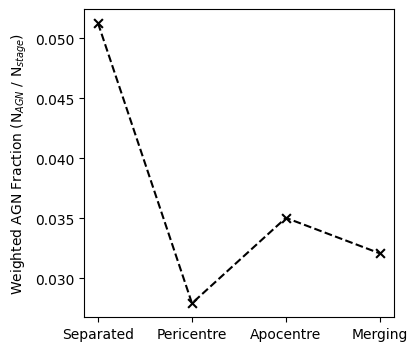

In [74]:
plt.figure(figsize = (4,4))
# plt.axhline(1.0, color = 'gray', linestyle = '--')
plt.scatter(x, unknown_fractions, color = 'black', s = 40, marker = 'x')
# plt.errorbar(x, fraction_list, color = 'black', yerr = error_array, alpha = 0.75, linestyle = '--', capsize = 3.5)
plt.plot(x, unknown_fractions, color='black', linestyle='--')
plt.ylabel('Weighted AGN Fraction (N$_{AGN}$ / N$_{stage}$)')
# plt.ylim([0.75,1.30])
# plt.savefig(f'{fig_folder}/agn-frac-time.pdf', bbox_inches = 'tight')
plt.show()

In [75]:
all_fractions = [
    agn_counts_s1 / (agn_counts_s1 + sfg_counts_s1 + unknown_counts_s1),
    agn_counts_s2 / (agn_counts_s2 + sfg_counts_s2 + unknown_counts_s2),
    agn_counts_s3 / (agn_counts_s3 + sfg_counts_s3 + unknown_counts_s3),
    agn_counts_s4 / (agn_counts_s4 + sfg_counts_s4 + unknown_counts_s4),
]
all_fractions

[0.05125, 0.027921406411582212, 0.0350385423966363, 0.03207810320781032]

In [76]:
def weight_dist(arrs, compare=1, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[compare], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    # hists.append(hist1)
    for i in arrs:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            if i_hist == compare:
                continue
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[compare][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[compare] >= b0) & (arrs[compare] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[compare] >  b0) & (arrs[compare] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[compare][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[compare][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[compare][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [77]:
df_agn = df_reclsf.query('all_clsf == "AGN"')
df_sfg = df_reclsf.query('all_clsf == "SFG"')
df_unknown = df_reclsf.query('all_clsf == "unknown"')

In [78]:
sfg_s1 = np.array(df_sfg.query('category == "stage1"')['lp_mass_best'])
sfg_s2 = np.array(df_sfg.query('category == "stage2"')['lp_mass_best'])
sfg_s3 = np.array(df_sfg.query('category == "stage3"')['lp_mass_best'])
sfg_s4 = np.array(df_sfg.query('category == "stage4"')['lp_mass_best'])

agn_s1 = np.array(df_agn.query('category == "stage1"')['lp_mass_best'])
agn_s2 = np.array(df_agn.query('category == "stage2"')['lp_mass_best'])
agn_s3 = np.array(df_agn.query('category == "stage3"')['lp_mass_best'])
agn_s4 = np.array(df_agn.query('category == "stage4"')['lp_mass_best'])

unknown_s1 = np.array(df_unknown.query('category == "stage1"')['lp_mass_best'])
unknown_s2 = np.array(df_unknown.query('category == "stage2"')['lp_mass_best'])
unknown_s3 = np.array(df_unknown.query('category == "stage3"')['lp_mass_best'])
unknown_s4 = np.array(df_unknown.query('category == "stage4"')['lp_mass_best'])

In [79]:
weights_sfg = weight_dist([sfg_s1, sfg_s2, sfg_s3, sfg_s4], compare=0, bins = 10, renorm = False, return_bins = False)

In [80]:
weights_unknown = weight_dist([unknown_s1, unknown_s2, unknown_s3, unknown_s4], compare=0, bins = 10, renorm = False, return_bins = False)

In [81]:
weights_agn = weight_dist([agn_s1, agn_s2, agn_s3, agn_s4], compare = 3, bins = 8, renorm = False, return_bins = False)

In [82]:
agn_n_weight_s1 = np.sum(weights_agn[0] * np.ones(len(agn_s1)))
agn_n_weight_s2 = np.sum(weights_agn[1] * np.ones(len(agn_s2)))
agn_n_weight_s3 = np.sum(weights_agn[2] * np.ones(len(agn_s3)))
agn_n_weight_s4 = np.sum(weights_agn[3] * np.ones(len(agn_s4)))

In [83]:
sfg_n_weight_s1 = np.sum(weights_sfg[0] * np.ones(len(sfg_s1)))
sfg_n_weight_s2 = np.sum(weights_sfg[1] * np.ones(len(sfg_s2)))
sfg_n_weight_s3 = np.sum(weights_sfg[2] * np.ones(len(sfg_s3)))
sfg_n_weight_s4 = np.sum(weights_sfg[3] * np.ones(len(sfg_s4)))

In [84]:
unknown_n_weight_s1 = np.sum(weights_unknown[0] * np.ones(len(unknown_s1)))
unknown_n_weight_s2 = np.sum(weights_unknown[1] * np.ones(len(unknown_s2)))
unknown_n_weight_s3 = np.sum(weights_unknown[2] * np.ones(len(unknown_s3)))
unknown_n_weight_s4 = np.sum(weights_unknown[3] * np.ones(len(unknown_s4)))

In [102]:
fraction_list = []
fraction_list.append(agn_n_weight_s1 / (agn_n_weight_s1 + sfg_n_weight_s1)) # + unknown_n_weight_s1))
fraction_list

[0.2727272727272727]

In [103]:
fraction_list.append(agn_n_weight_s2 / (agn_n_weight_s2 + sfg_n_weight_s2))# + unknown_n_weight_s2))

In [104]:
fraction_list.append(agn_n_weight_s3 / (agn_n_weight_s3 + sfg_n_weight_s3))# + unknown_n_weight_s3))

In [105]:
fraction_list.append(agn_n_weight_s4 / (agn_n_weight_s4 + sfg_n_weight_s4))# + unknown_n_weight_s4))

In [106]:
fraction_list

[0.2727272727272727,
 0.26153846153846155,
 0.30985915492957744,
 0.3142857142857143]

In [107]:
np.array(fraction_list) / fraction_list[0]

array([1.        , 0.95897436, 1.13615023, 1.15238095])

In [108]:
x = ['Separated', 'Pericentre', 'Apocentre','Merging']

In [109]:
relative_fraction_list = np.array(fraction_list) / fraction_list[0]

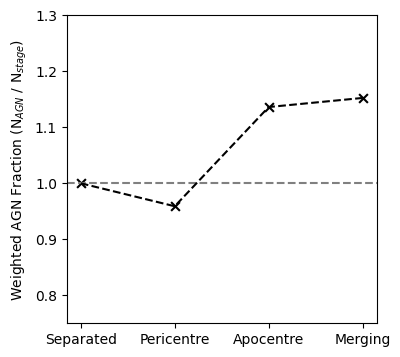

In [110]:
plt.figure(figsize = (4,4))
plt.axhline(1.0, color = 'gray', linestyle = '--')
plt.scatter(x, relative_fraction_list, color = 'black', s = 40, marker = 'x')
# plt.errorbar(x, fraction_list, color = 'black', yerr = error_array, alpha = 0.75, linestyle = '--', capsize = 3.5)
plt.plot(x, relative_fraction_list, color='black', linestyle='--')
plt.ylabel('Weighted AGN Fraction (N$_{AGN}$ / N$_{stage}$)')
plt.ylim([0.75,1.30])
# plt.savefig(f'{fig_folder}/agn-frac-time-relative.pdf', bbox_inches = 'tight')
plt.show()

## Finding Errors

In [164]:
def lower_beta(c, k, n):
    return dist.beta.ppf((1-c) / 2, k+1, n-k+1)

In [165]:
def upper_beta(c,k,n):
    return dist.beta.ppf(1-(1-c)/2, k+1, n-k+1)

In [166]:
c = 0.683
k = agn_n_weight_s1
n = (agn_n_weight_s1 + sfg_n_weight_s1 + unknown_n_weight_s1)

In [167]:
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c, k, n)

In [168]:
upper_p

0.05108379232670339

In [169]:
lower_p

0.033535501549508344

In [170]:
fraction_list

[0.2957746478873239,
 0.3142857142857143,
 0.3333333333333333,
 0.35064935064935066]

In [171]:
error_list = []
c = 0.683

k = len(agn_s1)
n = len(agn_s1) + len(sfg_s1) + len(unknown_s1)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[0] - lower_p, upper_p - fraction_list[0]])

k = len(agn_s2)
n = len(agn_s2) + len(sfg_s2) + len(unknown_s2)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[1] - lower_p, upper_p - fraction_list[1]])

k = len(agn_s3)
n = len(agn_s3) + len(sfg_s3) + len(unknown_s3)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[2] - lower_p, upper_p - fraction_list[2]])

k = len(agn_s4)
n = len(agn_s4) + len(sfg_s4) + len(unknown_s4)
upper_p = upper_beta(c, k, n)
lower_p = lower_beta(c,k,n)
error_list.append([fraction_list[3] - lower_p, upper_p - fraction_list[3]])